# EDA of US-Accidents

- Understanding Accident Trends: EDA can reveal trends in accident frequency over time, seasonal    variations, and any notable spikes or decreases.

- Identifying High-Risk Areas: Analysis of accident locations can help identify regions with a high frequency of accidents, assisting authorities in implementing targeted safety measures.

- Examining Contributing Factors: By exploring variables such as weather conditions, road conditions, and time of day, insights can be gained into factors contributing to accidents.

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, desc, avg, to_timestamp, hour, date_format, month, year, when, mean, corr, round
from pyspark.sql.types import IntegerType, StringType
from dotenv import load_dotenv
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:

load_dotenv()
key_filepath = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

In [3]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("US Accidents") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile",key_filepath  ) \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/05/09 19:52:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/09 19:52:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [5]:
# Read Parquet files from GCS
parquet_files = [
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2016/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2017/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2018/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2019/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2020/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2021/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2022/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2023/933c14c388864f19a17c514e311a69b1-0.parquet"
                ]

df_list = [spark.read.option("header", "true").option("inferSchema", "true").parquet(file) for file in parquet_files]

merged_df = df_list[0]
for df in df_list[1:]:
    merged_df = merged_df.unionAll(df)

In [ ]:
merged_df.describe()

## Data Preparation and Cleaning

In [ ]:
from pyspark.sql.functions import count, col

# Count null values for each column
null_counts = merged_df.select([count(col(c)).alias(c) for c in merged_df.columns])

# Calculate total row count
total_rows = merged_df.count()

# Subtract non-null counts from total row count to get null counts for each column
for col_name in merged_df.columns:
    null_counts = null_counts.withColumn(col_name, total_rows - col(col_name))

# Display null value counts for each column
null_counts.show()


24/05/05 13:44:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+------+--------+----------+--------+---------+---------+------------+-----------+------+----+------+-----+-------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------+-------+-------+---------------+--------------+--------------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|Description|Street|City|County|State|Country|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Weather_Condition|Crossing|Railway|Station|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|
+---+------+--------+----------+--------+---------+---------+------------+-----------+------+----+------+-----+-------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------+-------+-------+---------------+--------------+--------------+
|  0|     0|       0|         0|       0|        0|        0|           0

In [ ]:
# Calculate missing value percentages for each column
missing_value_percentages = null_counts.select(
    [(col(c) / total_rows * 100).alias(c + "_percentage") for c in merged_df.columns]
)

# Display missing value percentages for each column
missing_value_percentages.show()

+-------------+-----------------+-------------------+---------------------+-------------------+--------------------+--------------------+-----------------------+----------------------+------------------+--------------------+-----------------+----------------+------------------+-------------------------+------------------------+----------------------+-----------------------+-------------------------+-------------------------+--------------------------+----------------------------+-------------------+------------------+------------------+--------------------------+-------------------------+-------------------------+
|ID_percentage|Source_percentage|Severity_percentage|Start_Time_percentage|End_Time_percentage|Start_Lat_percentage|Start_Lng_percentage|Distance(mi)_percentage|Description_percentage| Street_percentage|     City_percentage|County_percentage|State_percentage|Country_percentage|Temperature(F)_percentage|Wind_Chill(F)_percentage|Humidity(%)_percentage|Pressure(in)_percentage|Vi

<Axes: >

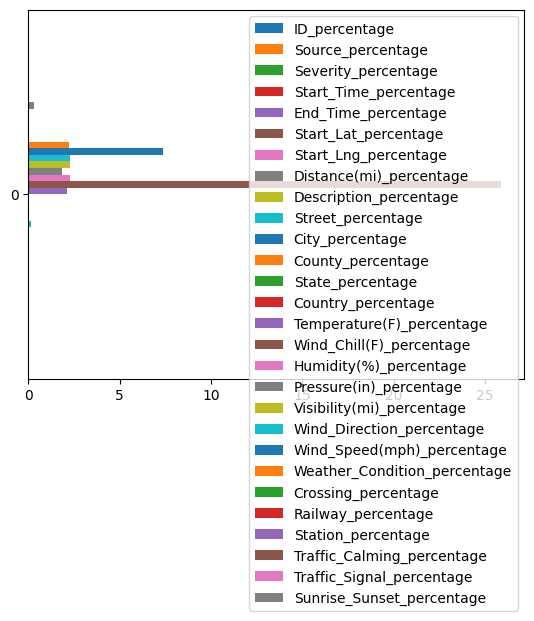

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
missing_value_percentages_pd = missing_value_percentages.toPandas()


# Filter out columns with non-zero null value percentages
missing_value_percentages_filtered_pd = missing_value_percentages_pd.loc[
    (missing_value_percentages_pd != 0).any(axis=1)
]

missing_value_percentages_filtered_pd.plot(kind='barh')

In [6]:
# Drop nulls
merged_df = merged_df.dropna()

## Exploratory Analysis and Visualization

In [ ]:
# Select the 'City' column from the PySpark DataFrame
city_column = merged_df.select('City')

# Show the first few rows of the 'City' column
city_column.show()

+------------+
|        City|
+------------+
|Williamsburg|
|      Dayton|
|      Dayton|
| Westerville|
|      Dayton|
|      Dayton|
| Westerville|
|    Columbus|
|Reynoldsburg|
|      Dayton|
|    Columbus|
|      Dayton|
|      Dayton|
|      Dayton|
|    Columbus|
|      Dayton|
|  Miamisburg|
|    Columbus|
|      Dayton|
|   Johnstown|
+------------+
only showing top 20 rows



In [ ]:
# Count the number of unique cities in the 'City' column
unique_cities = merged_df.select('City').distinct()
unique_city_count = unique_cities.count()

# Display the number of unique cities
print("Number of unique cities:", unique_city_count)

# Display the first 10 cities
unique_cities.show(10)

Number of unique cities: 11729


+-------------+
|         City|
+-------------+
|Bowling Green|
|      Batavia|
|      Moraine|
|       Auburn|
|   Georgetown|
|Lake Elsinore|
|    Pittsburg|
|     Woodland|
|Browns Valley|
|   Menlo Park|
+-------------+
only showing top 10 rows



In [ ]:
# Group the data by 'City' and count the number of occurrences
city_accident_counts = merged_df.groupBy('City').count()

# Sort the result in descending order based on the accident counts
city_accident_counts = city_accident_counts.orderBy(desc('count'))

# Get the city with the highest number of accidents
highest_accident_city = city_accident_counts.first()

# Display the city with the highest number of accidents
print("City with the highest number of accidents:", highest_accident_city['City'])
print("Number of accidents:", highest_accident_city['count'])

City with the highest number of accidents: Miami
Number of accidents: 158736


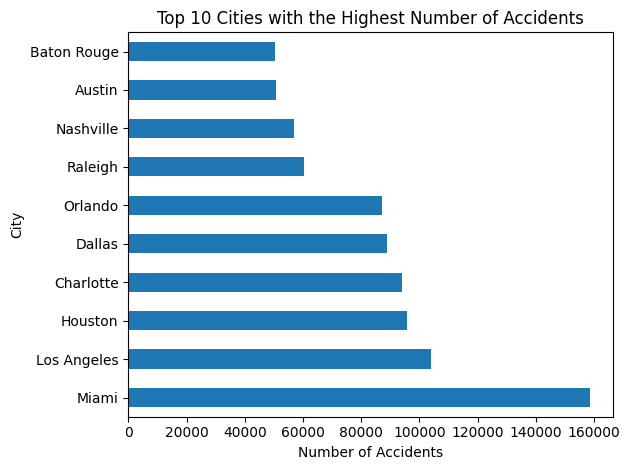

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
city_accident_counts_pandas = city_accident_counts.toPandas()

# Set 'City' column as the index
city_accident_counts_pandas.set_index('City', inplace=True)

# Plot the first 10 cities with the highest number of accidents
city_accident_counts_pandas[:10].plot(kind='barh', legend=None)
plt.title('Top 10 Cities with the Highest Number of Accidents')
plt.xlabel('Number of Accidents')
plt.ylabel('City')
plt.tight_layout()
plt.show()

<Axes: ylabel='Count'>

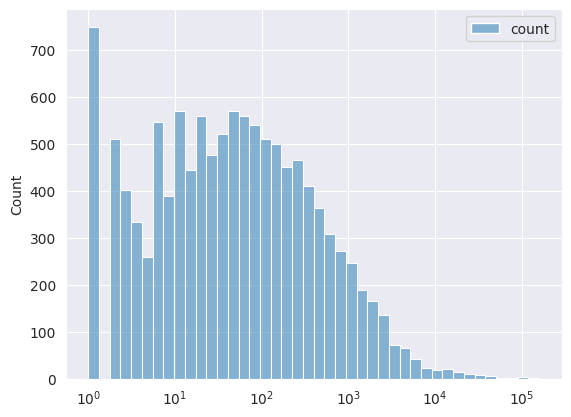

In [ ]:
sns.set_style('darkgrid')

sns.histplot(city_accident_counts_pandas, log_scale=True)

### From the above graph we can analyze that distribution of accident is more between ten to hundred. When it goes further its decreasing exponentially.

In [7]:
# Convert the Severity to integer
merged_df = merged_df.withColumn("Severity", merged_df["Severity"].cast(IntegerType()))

In [ ]:
count_severity_df = merged_df.groupBy('Severity').count()

# Sort the result in descending order based on the severity counts
count_severity_df = count_severity_df.orderBy(desc('count'))

# Get the Severity with the highest number of accidents
highest_severity = count_severity_df.first()

# Display the Severity with the highest number of accidents
print("Severity with the highest accidents count:", highest_severity['Severity'])
print("Number of accidents:", highest_severity['count'])

Severity with the highest accidents count: 2
Number of accidents: 4756722


In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
count_severity_pandas = count_severity_df.toPandas()

In [ ]:
values = [x[1] for x in count_severity_pandas.values]
keys = [x[0] for x in count_severity_pandas.values]


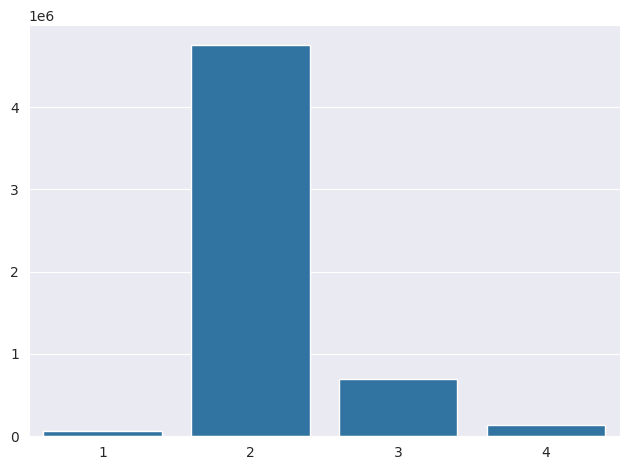

In [ ]:
sns.barplot(x=keys, y=values)
plt.tight_layout()

### From the above graph we conclude that the class of severity = 2 has the majority 

In [ ]:
# Calculate average severity per city
average_severity_per_city = merged_df.groupBy('City').agg(avg('Severity')).alias('average_severity').orderBy(desc('avg(Severity)'))

# Display the average severity per city
average_severity_per_city.show()

+--------------------+-------------+
|                City|avg(Severity)|
+--------------------+-------------+
|           Marinette|          4.0|
|            Ackerman|          4.0|
|          Cold Brook|          4.0|
|         Black River|          4.0|
|           Eagle Bay|          4.0|
|          Mc Dermott|          4.0|
|       S Coffeyville|          4.0|
|            Richboro|          4.0|
|               Adena|          4.0|
|       Iron Mountain|          4.0|
|       Mount Tremper|          4.0|
|          Mulkeytown|          4.0|
|           Valentine|          4.0|
|              Bisbee|          4.0|
|         Lumberville|          4.0|
|       South Whitley|          4.0|
|                Juda|          4.0|
|           Rose City|          4.0|
|Houghton Lake Hei...|          4.0|
|          Two Rivers|          4.0|
+--------------------+-------------+
only showing top 20 rows



<Axes: ylabel='Count'>

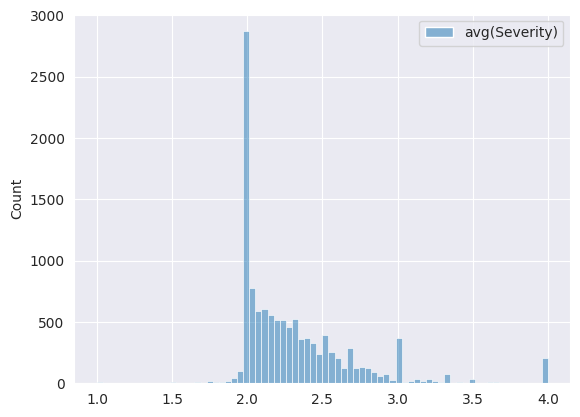

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
average_severity_per_city_pandas = average_severity_per_city.toPandas()

sns.set_style('darkgrid')
sns.histplot(average_severity_per_city_pandas, log_scale=False)

#### From the above graph, most of the cities have average severity = 2

## Start Time Analysis

In [8]:
# Convert "Start_Time" and "End_Time" columns to datetime format
merged_df = merged_df.withColumn("Start_Time", to_timestamp(merged_df["Start_Time"], "yyyy-MM-dd HH:mm:ss"))
merged_df = merged_df.withColumn("End_Time", to_timestamp(merged_df["End_Time"], "yyyy-MM-dd HH:mm:ss"))

In [31]:
# Create a new column called Duration = End_Time - Start_Time
# To indicate the duration of the accident
from pyspark.sql.functions import col, unix_timestamp

# Convert "Start_Time" and "End_Time" columns to Unix timestamp (seconds since the epoch)
merged_df = merged_df.withColumn("Start_Time_unix", unix_timestamp("Start_Time"))
merged_df = merged_df.withColumn("End_Time_unix", unix_timestamp("End_Time"))

# Calculate the duration (in seconds)
merged_df = merged_df.withColumn("Duration", round((col("End_Time_unix") - col("Start_Time_unix")) / 60.0, 2))

In [32]:
count_duration_df = merged_df.groupBy('Duration').count()

# Sort the result in descending order based on the duration counts
count_duration_df = count_duration_df.orderBy(desc('count'))

In [33]:
count_duration_df.show()

+--------+-----+
|Duration|count|
+--------+-----+
|   360.0|60147|
|    75.0|52955|
|    30.0|46078|
|   240.0|41221|
|    15.0|39671|
|    60.0|35837|
|   105.0|34198|
|    45.0|27287|
|   75.02|24964|
|    20.0|24792|
|   120.0|20641|
|   29.75|19858|
|   29.73|19779|
|   29.72|19687|
|   29.77|19529|
|    29.7|19471|
|   29.68|18883|
|   29.78|18492|
|   29.67|18101|
|   29.65|17752|
+--------+-----+
only showing top 20 rows



In [34]:
# Extract the hour from the "Start_Time" column
merged_df = merged_df.withColumn('Start_Hour', hour(merged_df['Start_Time']))
merged_df.show(2)

+---+-------+--------+-------------------+-------------------+---------+------------------+------------+--------------------+--------------+------------+----------+-----+-------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------+-------+-------+---------------+--------------+--------------+---------------+-------------+--------+----------+-----------+------------+-----------+--------------------+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|         Start_Lng|Distance(mi)|         Description|        Street|        City|    County|State|Country|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Weather_Condition|Crossing|Railway|Station|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|Start_Time_unix|End_Time_unix|Duration|Start_Hour|Day_Of_Week|Month_Of_Acc|Year_Of_Acc|Temperature_Category|
+---+-------+--------+-------------------+------

#### Show the distribution of number of accidents per hours 

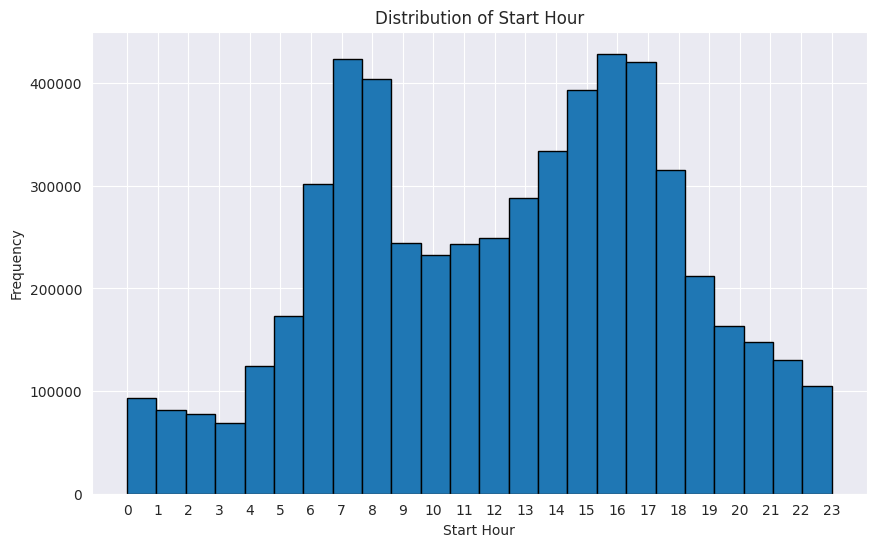

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
start_hour_pd = merged_df.select('Start_Hour').toPandas()

# Plot histogram of the 'Start_Hour' column
plt.figure(figsize=(10, 6))
plt.hist(start_hour_pd['Start_Hour'], bins=24, edgecolor='black')
plt.title('Distribution of Start Hour')
plt.xlabel('Start Hour')
plt.ylabel('Frequency')
plt.xticks(range(24))  # Set x-axis ticks to represent each hour of the day
plt.grid(True)
plt.show()

#### Show the distribution of number of accidents per days of week 

In [35]:
# Extract the day from the "Start_Time" column
# 'EEEE' in the date_format function stands for the full name of the day of the week
merged_df = merged_df.withColumn('Day_Of_Week', date_format(merged_df['Start_Time'], 'EEEE'))
merged_df.show(2)

+---+-------+--------+-------------------+-------------------+---------+------------------+------------+--------------------+--------------+------------+----------+-----+-------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------+-------+-------+---------------+--------------+--------------+---------------+-------------+--------+----------+-----------+------------+-----------+--------------------+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|         Start_Lng|Distance(mi)|         Description|        Street|        City|    County|State|Country|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Weather_Condition|Crossing|Railway|Station|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|Start_Time_unix|End_Time_unix|Duration|Start_Hour|Day_Of_Week|Month_Of_Acc|Year_Of_Acc|Temperature_Category|
+---+-------+--------+-------------------+------

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
start_day_pd = merged_df.select('Day_Of_Week').toPandas()

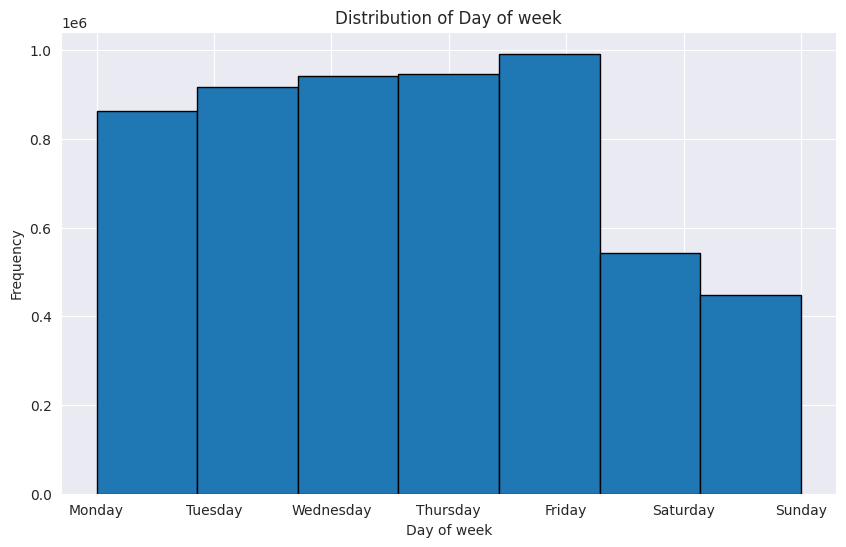

In [ ]:

# Plot histogram of the 'Day_Of_Week' column
plt.figure(figsize=(10, 6))
plt.hist(start_day_pd['Day_Of_Week'], bins=7, edgecolor='black')
plt.title('Distribution of Day of week')
plt.xlabel('Day of week')
plt.ylabel('Frequency')
plt.xticks(range(7))  # Set x-axis ticks to represent each day
plt.grid(True)
plt.show()

In [36]:
# Extract the month from the "Start_Time" column
merged_df = merged_df.withColumn('Month_Of_Acc', month(merged_df['Start_Time']))
merged_df.show(2)

+---+-------+--------+-------------------+-------------------+---------+------------------+------------+--------------------+--------------+------------+----------+-----+-------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------+-------+-------+---------------+--------------+--------------+---------------+-------------+--------+----------+-----------+------------+-----------+--------------------+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|         Start_Lng|Distance(mi)|         Description|        Street|        City|    County|State|Country|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Weather_Condition|Crossing|Railway|Station|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|Start_Time_unix|End_Time_unix|Duration|Start_Hour|Day_Of_Week|Month_Of_Acc|Year_Of_Acc|Temperature_Category|
+---+-------+--------+-------------------+------

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
start_month_pd = merged_df.select('Month_Of_Acc').toPandas()

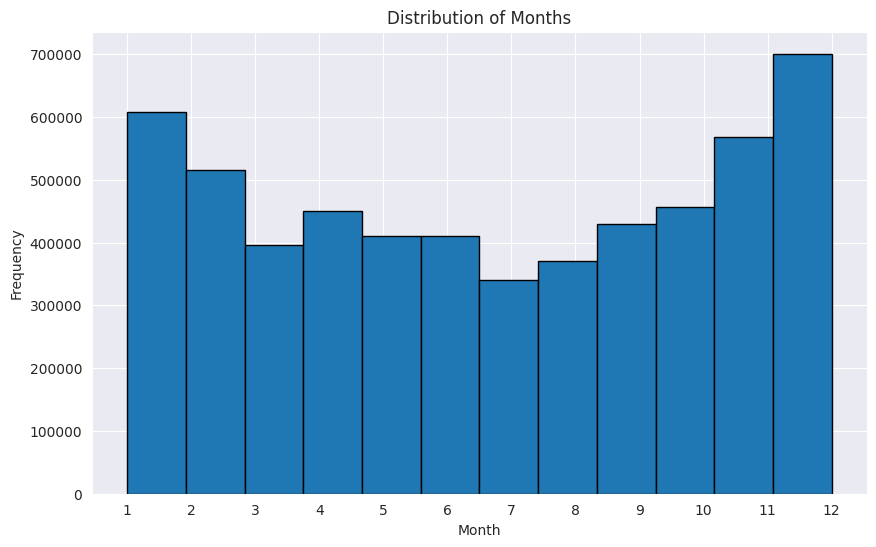

In [ ]:
# Plot histogram of the 'Day_Of_Week' column
plt.figure(figsize=(10, 6))
plt.hist(start_month_pd['Month_Of_Acc'], bins=12, edgecolor='black')
plt.title('Distribution of Months')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 13))  # Set x-axis ticks to represent each month
plt.grid(True)
plt.show()

#### Initially, there is a high number of accidents, which gradually decreases as the months progress. However, towards the end of the year, there is a slight increase in the number of accidents again. 

In [37]:
# Extract the year from the "Start_Time" column
merged_df = merged_df.withColumn('Year_Of_Acc', year(merged_df['Start_Time']))
merged_df.show(2)

+---+-------+--------+-------------------+-------------------+---------+------------------+------------+--------------------+--------------+------------+----------+-----+-------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------+-------+-------+---------------+--------------+--------------+---------------+-------------+--------+----------+-----------+------------+-----------+--------------------+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|         Start_Lng|Distance(mi)|         Description|        Street|        City|    County|State|Country|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Weather_Condition|Crossing|Railway|Station|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|Start_Time_unix|End_Time_unix|Duration|Start_Hour|Day_Of_Week|Month_Of_Acc|Year_Of_Acc|Temperature_Category|
+---+-------+--------+-------------------+------

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
start_year_pd = merged_df.select('Year_Of_Acc').toPandas()

<Axes: xlabel='Year_Of_Acc', ylabel='Percent'>

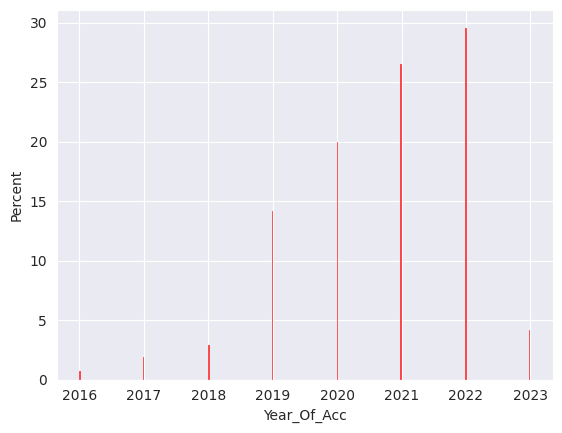

In [ ]:
sns.histplot(start_year_pd['Year_Of_Acc'], stat="percent", color="red")


#### From the graph we can analyze that accidents are increasing every year but we can see 2023 have the lowest accident recorded. Thats really unusual. We need to see the data of 2023.

In [ ]:
# Filter the data in 2023 to visualize it
data_23 = merged_df.filter(merged_df['Year_Of_Acc'] == 2023)

In [ ]:
data_23.show(2)

+---------+-------+--------+-------------------+-------------------+---------+----------+------------------+--------------------+-----------+-----------+----------+-----+-------+--------------+-------------+-----------+------------+--------------+--------------+---------------+--------------------+--------+-------+-------+---------------+--------------+--------------+----------+-----------+------------+-----------+
|       ID| Source|Severity|         Start_Time|           End_Time|Start_Lat| Start_Lng|      Distance(mi)|         Description|     Street|       City|    County|State|Country|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|   Weather_Condition|Crossing|Railway|Station|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|Start_Hour|Day_Of_Week|Month_Of_Acc|Year_Of_Acc|
+---------+-------+--------+-------------------+-------------------+---------+----------+------------------+--------------------+-----------+-----------+---------

In [ ]:
# Select unique values of the 'Month_Of_Acc' column
unique_months = data_23.select('Month_Of_Acc').distinct()

# Show the unique months
unique_months.show()

+------------+
|Month_Of_Acc|
+------------+
|           1|
|           3|
|           2|
+------------+



In [ ]:
months_2023_pd = data_23.select('Month_Of_Acc').toPandas()

<Axes: xlabel='Month_Of_Acc', ylabel='Count'>

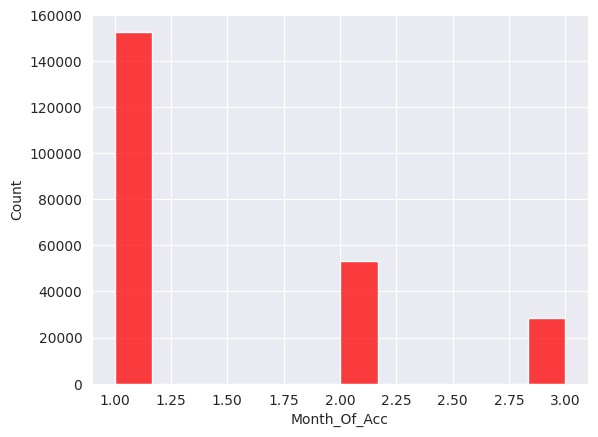

In [ ]:
# Plot the distribution of the months
sns.histplot(months_2023_pd['Month_Of_Acc'], bins=12, color='red')

#### The reason for the seemingly lower number of accidents in 2023 is primarily due to data availability. The dataset used for analysis only includes data up to March 2023, which means it doesn't cover the entire year. As a result, the observed decrease in accidents for 2023 may not accurately reflect the true accident rate for the entire year, as data for the later months is missing. Therefore, any conclusions drawn about accident trends in 2023 should be approached with caution, keeping in mind the incomplete data for that year.

--- 

## Start Latitude and Start Langitude


In [ ]:
df_pandas = merged_df.select('Start_Lat', 'Start_Lng').toPandas()

24/05/05 15:04:34 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
sample_df=df_pandas.sample(int(0.1*len(df_pandas))) 

<Axes: xlabel='Start_Lng', ylabel='Start_Lat'>

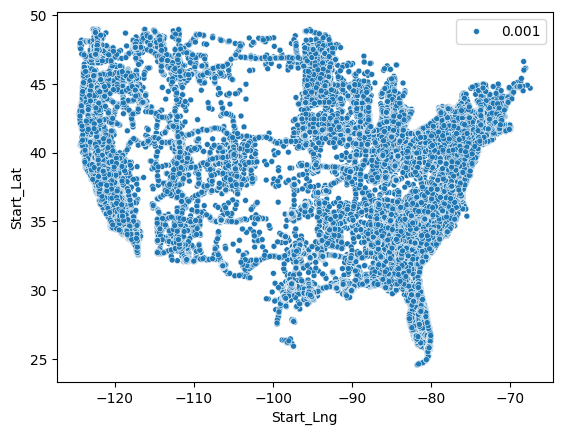

In [ ]:
sns.scatterplot(x=sample_df.Start_Lng, y=sample_df.Start_Lat, size=0.001)

## Weather

### 1.Are there more accidents in warmer or colder areas?


In [38]:
# Define temperature bins and labels
bins = [0, 50, 75, 100]
labels = ['Cold', 'Moderate', 'Warm']

# Use 'when' function to assign temperature categories based on the bins
temperature_category_column = when(merged_df['Temperature(F)'] <= 50, 'Cold') \
    .when((merged_df['Temperature(F)'] > 50) & (merged_df['Temperature(F)'] <= 75), 'Moderate') \
    .otherwise('Warm')

# Add the temperature category column to the DataFrame
merged_df = merged_df.withColumn('Temperature_Category', temperature_category_column)

# Display the DataFrame with the new temperature category column
merged_df.select('Temperature_Category').show()

+--------------------+
|Temperature_Category|
+--------------------+
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
|                Cold|
+--------------------+
only showing top 20 rows



In [ ]:
# Group by temperature category and count the number of accidents
accidents_by_temperature = merged_df.groupBy('Temperature_Category').agg(count('*').alias('Accidents'))

# Show the result
accidents_by_temperature.show()

+--------------------+---------+
|Temperature_Category|Accidents|
+--------------------+---------+
|                Cold|  1800430|
|                Warm|  1393745|
|            Moderate|  2462664|
+--------------------+---------+



In [ ]:

# Convert the result to Pandas DataFrame for plotting
accidents_by_temperature_pd = accidents_by_temperature.toPandas()

<Axes: ylabel='count'>

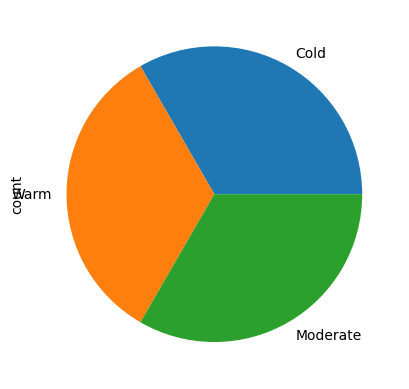

In [ ]:
accidents_by_temperature_pd['Temperature_Category'].value_counts().plot(kind='pie')

### 2. Frequency of Weather Conditions

In [ ]:
# Group by weather condition and count the frequency of each condition
weather_frequency = merged_df.groupBy('Weather_Condition').agg(count('*').alias('Frequency')).orderBy(desc('Frequency'))

# Show the result
weather_frequency.show()

+--------------------+---------+
|   Weather_Condition|Frequency|
+--------------------+---------+
|                Fair|  2501947|
|              Cloudy|   800733|
|       Mostly Cloudy|   737259|
|       Partly Cloudy|   511339|
|          Light Rain|   264342|
|          Light Snow|   123498|
|               Clear|   110169|
|            Overcast|   103646|
|                 Fog|    87189|
|                Rain|    63040|
|                Haze|    50581|
|        Fair / Windy|    35049|
|          Heavy Rain|    23620|
|    Scattered Clouds|    22805|
|Thunder in the Vi...|    17118|
|       Light Drizzle|    16851|
|      Cloudy / Windy|    16628|
|Mostly Cloudy / W...|    16347|
|             T-Storm|    16337|
|                Snow|    14581|
+--------------------+---------+
only showing top 20 rows



In [ ]:
weather_frequency_pandas = weather_frequency.toPandas()

In [ ]:
top_n = 10 
weather_frequency_pandas

,Weather_Condition,Frequency
0,Fair,2501947
1,Cloudy,800733
2,Mostly Cloudy,737259
3,Partly Cloudy,511339
4,Light Rain,264342
...,...,...
131,Heavy Rain Shower / Windy,1
132,Blowing Snow Nearby,1
133,Blowing Sand,1
134,Heavy Freezing Rain / Windy,1


<Figure size 1000x600 with 0 Axes>

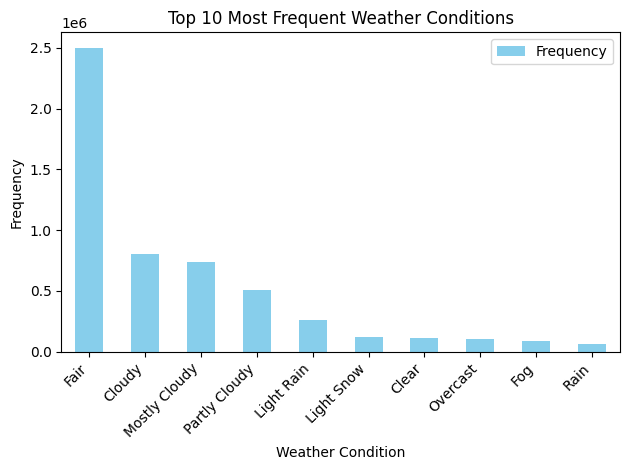

In [ ]:
top_n = 10 
top_n_weather = weather_frequency_pandas.head(top_n)

# Plot the bar plot
plt.figure(figsize=(10, 6))
top_n_weather.plot(kind='bar', color='skyblue',x='Weather_Condition', y='Frequency')
plt.title(f'Top {top_n} Most Frequent Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 3. Impact of Weather on Accident Severity

In [ ]:
weather_severity_df = merged_df.select('Weather_Condition', 'Severity')

In [ ]:
# Group data by weather condition and calculate mean severity

severity_by_weather = weather_severity_df.groupBy('Weather_Condition').agg(mean('Severity').alias('Mean_Severity')).orderBy(desc('Mean_Severity'))

severity_by_weather.show()


+--------------------+------------------+
|   Weather_Condition|     Mean_Severity|
+--------------------+------------------+
|  Light Blowing Snow|3.6666666666666665|
|Patches of Fog / ...| 3.142857142857143|
|           Light Fog|               3.0|
|Heavy Freezing Ra...|               3.0|
|          Light Hail|               3.0|
| Partial Fog / Windy|               3.0|
|Heavy Thunderstor...|               2.8|
|Light Thunderstor...| 2.772727272727273|
|   Heavy Ice Pellets|              2.75|
|  Heavy Blowing Snow|              2.75|
|  Light Snow Showers|2.6956521739130435|
|Drifting Snow / W...|2.6666666666666665|
|       Smoke / Windy|2.6315789473684212|
|Heavy Snow with T...|             2.625|
|   Low Drifting Snow|               2.6|
|   Light Ice Pellets| 2.526530612244898|
|Thunderstorms and...| 2.511904761904762|
|Light Thunderstor...| 2.511278195488722|
|        Snow Showers|               2.5|
|   Light Snow Grains|               2.5|
+--------------------+------------

In [ ]:
severity_by_weather_pandas = severity_by_weather.toPandas()

/tmp/ipykernel_2743/3266835807.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mean_Severity', y='Weather_Condition', data=severity_by_weather_pandas, palette='viridis')


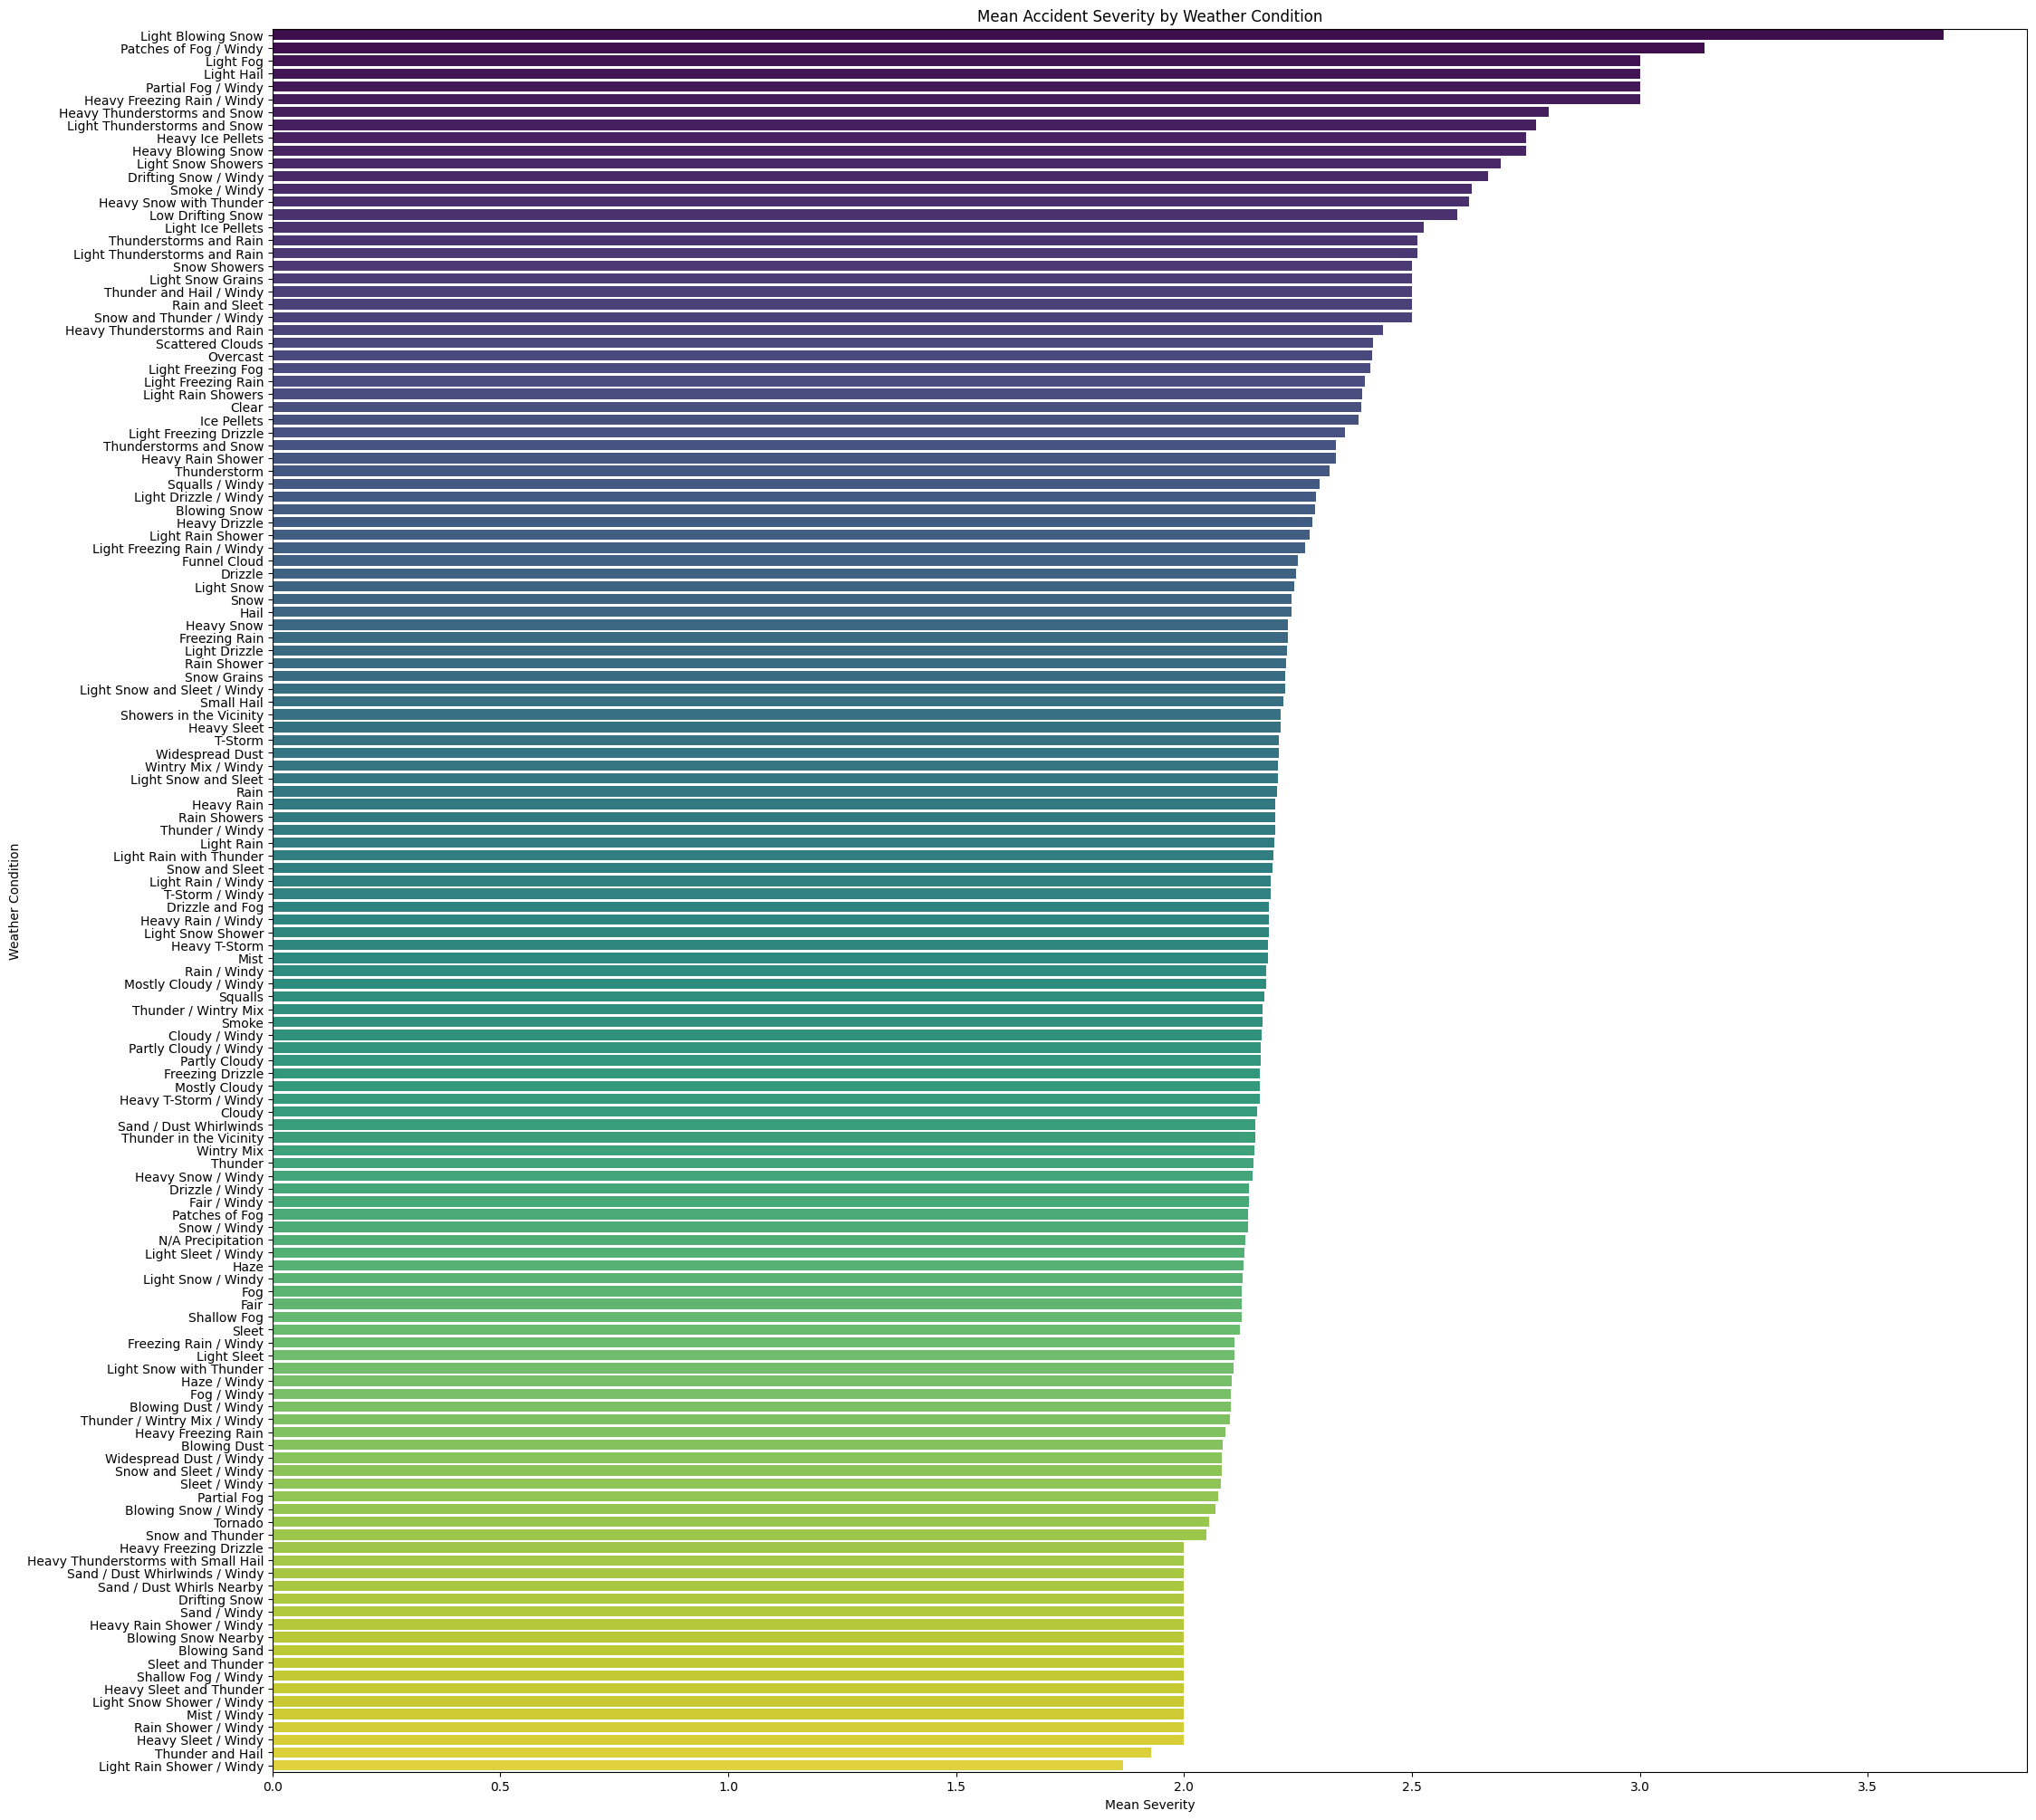

In [ ]:
# Plot the relationship between weather conditions and accident severity
plt.figure(figsize=(25, 25))
sns.barplot(x='Mean_Severity', y='Weather_Condition', data=severity_by_weather_pandas, palette='viridis')
plt.title('Mean Accident Severity by Weather Condition')
plt.xlabel('Mean Severity')
plt.ylabel('Weather Condition')
plt.show()

#### Light blowing snow is a weather condition characterized by light snowfall accompanied by strong winds that cause the snow to be lifted from the ground and blown around. This weather condition can significantly reduce visibility and create hazardous driving conditions. Overall, it poses significant hazards to drivers and can contribute to the severity of accidents by reducing visibility, creating slippery road conditions, and increasing the likelihood of collisions.

In [50]:
merged_df.show(1)

+---+-------+--------+-------------------+-------------------+---------+----------+------------+--------------------+--------------+------------+--------+-----+-------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------+-------+-------+---------------+--------------+--------------+----------+-----------+------------+-----------+--------------------+---------------+-------------+--------+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat| Start_Lng|Distance(mi)|         Description|        Street|        City|  County|State|Country|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Weather_Condition|Crossing|Railway|Station|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|Start_Hour|Day_Of_Week|Month_Of_Acc|Year_Of_Acc|Temperature_Category|Start_Time_unix|End_Time_unix|Duration|
+---+-------+--------+-------------------+-------------------+------

### Analysis for Description of the accident

In [32]:
top_1000_description = merged_df.select('Description').filter(col("Description").isNotNull()).sort(col("Severity").desc()).limit(1000).collect()


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    ignore_char = ['\r', '\n', '', ' ', '``', "'s"]
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    words_lower = [token.lower() for token in words if token.isalpha() and token not in ignore_char]
    words_final = [lemmatizer.lemmatize(word) for word in words_lower if word not in stop_words]
    return words_final


In [33]:
description_preprocessed = [preprocess_text(row.Description) for row in top_1000_description]
description_preprocessed = ' '.join([' '.join(row) for row in description_preprocessed])

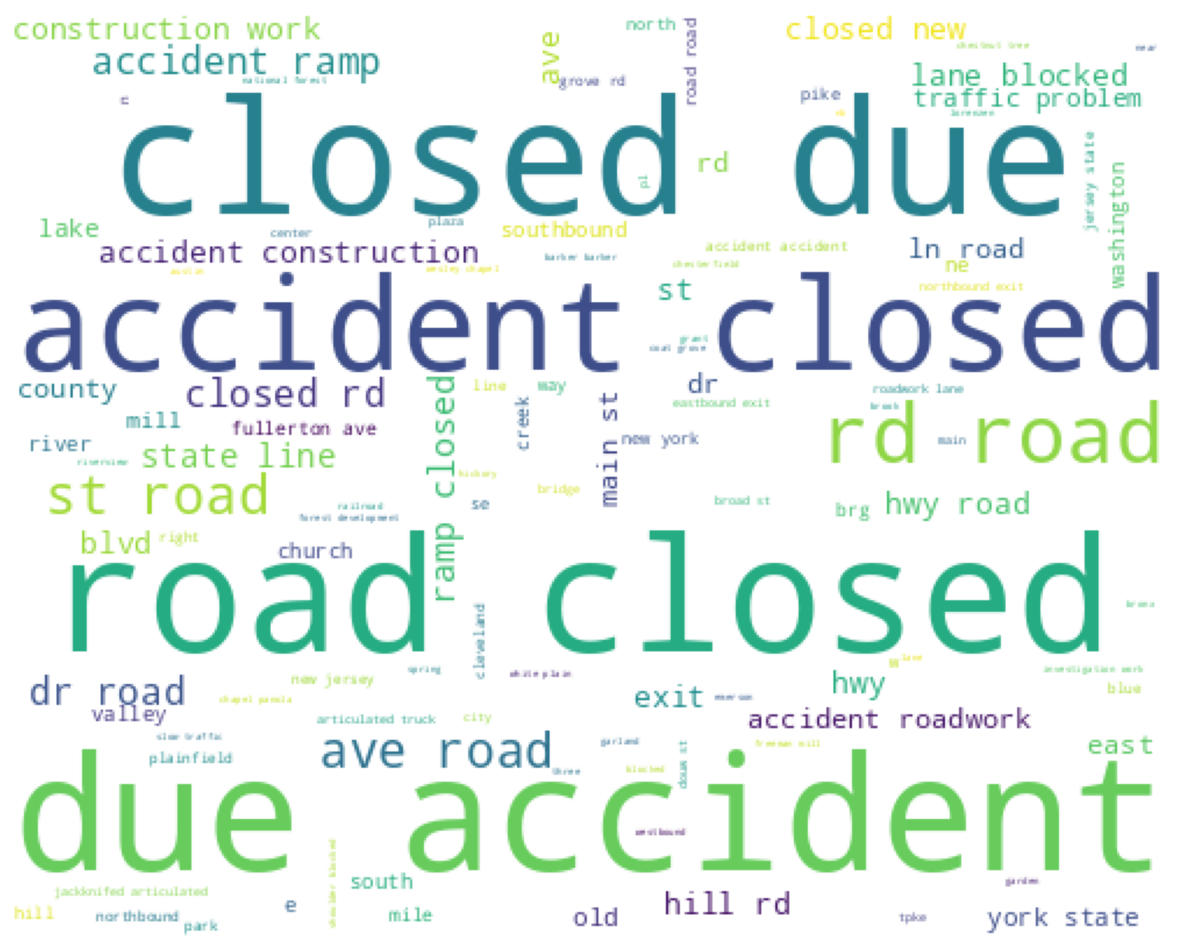

In [34]:
from wordcloud import WordCloud

wordcloud = WordCloud(width= 500, height= 400, background_color="white").generate(description_preprocessed)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Correlation matrix

In [39]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation

# Assuming you have categorical and boolean columns that need to be encoded
categorical_cols = ['Source', 'State', 'Weather_Condition', 'Sunrise_Sunset', 'Temperature_Category', 'Wind_Direction']

boolean_cols = ['Crossing', 'Railway', 'Station', 'Traffic_Calming', 'Traffic_Signal']

rest_cols = ['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Duration', 'Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)', 'Wind_Speed(mph)']
# Create stages for encoding categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_cols]

# Convert boolean columns to numerical representations
# No need to apply StringIndexer, boolean columns are already numerical
# Simply append "_index" to the column name
numeric_cols = [col+"_index" if col in categorical_cols else col for col in boolean_cols + categorical_cols + rest_cols]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")

# Create a pipeline
pipeline = Pipeline(stages=indexers + [assembler])

# Fit and transform the data
pipeline_model = pipeline.fit(merged_df)
transformed_df = pipeline_model.transform(merged_df)




In [40]:
import pyspark 

# transformed_df filter only numeric columns only
transformed_df = transformed_df.select([col for col in transformed_df.columns if transformed_df.schema[col].dataType == pyspark.sql.types.DoubleType() or transformed_df.schema[col].dataType == pyspark.sql.types.IntegerType() or transformed_df.schema[col].dataType == pyspark.sql.types.LongType()]).toPandas() 

<Axes: >

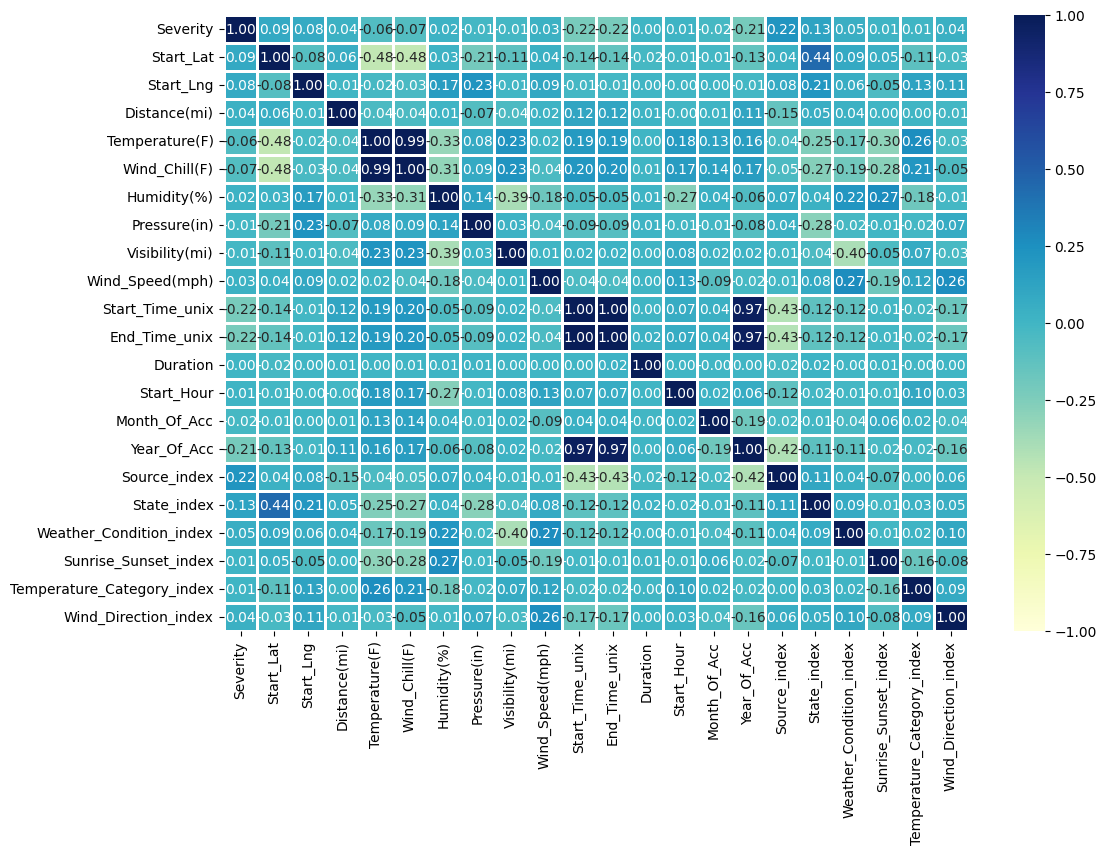

In [41]:
import seaborn as sb

# show heatmap correlation with price and other columns in the df
plt.figure(figsize = (12, 8))
sb.heatmap(transformed_df.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 10}, cmap = "YlGnBu")

## Summary and Conclusion

- The dataset only includes data for 49 states.
- Miami has the highest number of reported accidents.
- The frequency of accidents per city follows an exponential decrease pattern.
- Only 13.5% of cities have more accidents than the average.
- Accidents are most common between 8 am to 10 am and 3 pm to 6 pm, suggesting a higher likelihood during peak commuting hours.
- Weekdays show a higher number of accidents compared to weekends.
- The year 2023 has the lowest number of reported accidents, likely due to data availability only until March 2023.
- Coastal areas experience higher accident rates compared to inland regions.
- The top 10 most frequent weather conditions for accidents are: Fair, Mostly Cloudy, Cloudy, Clear, Partly Cloudy, Overcast, Light Rain, Scattered Clouds, Light Snow, and Fog.
- Analyzing the relationship between weather conditions and accident severity revealed the following insights:
    - Light Blowing Snow has the highest average severity at 3.67.
    - Patches of Fog / Windy, Heavy Freezing Rain / Windy, and Light Fog have average severities of 3.14, 3.00, and 3.00, respectively.
    - Partial Fog / Windy, Heavy Thunderstorms and Snow, Light Thunderstorms and Snow, Heavy Ice Pellets, Heavy Blowing Snow, and Drifting Snow / Windy also show significant average severity levels.